In [1]:
from plotting_utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import rankdata, ttest_ind
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from itertools import combinations

In [2]:
datasets = [
    "Sulfonyl Fluoride 1", "Sulfonyl Fluoride 2", "Sulfonyl Fluoride 3", "Sulfonyl Fluoride 4", "Sulfonyl Fluoride 5", 
    "Amide", "Amine", "Sulfonamide", "Thiol", 
    "Whole amine", "Whole bromide"
]
all_models_ordered = ["Baseline", "RFR", "RFC", "KNN", "LRRF", "RPC", "IBM", "IBPL"]
rf_based_models_ordered = ["Baseline", "RFR", "RFC", "LRRF", "RPC"]

# Complete datasets with four reaction conditions

## Fingerprints

In [3]:
fp_analyzer = Analyzer("fp", all_models_ordered, 0)
fp_perf_df = fp_analyzer.avg_perf_df

fp_rr_table, fp_kt_table = get_rr_kt_tables(fp_perf_df, all_models_ordered)
p_rr, p_kt = run_friedman_tests(fp_rr_table, fp_kt_table, all_models_ordered)

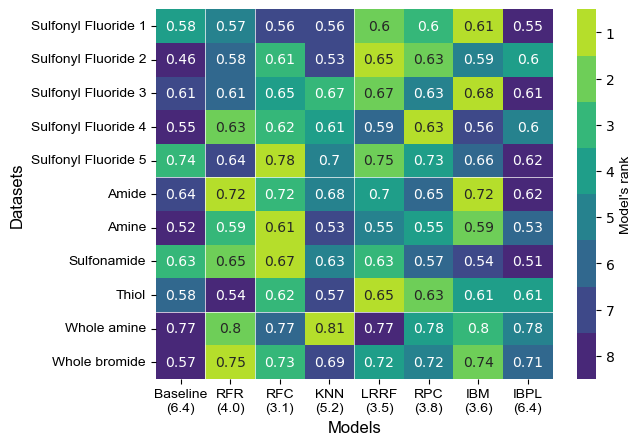

In [4]:
plot_rr_heatmap(fp_rr_table, all_models_ordered, datasets)

## DFT

In [5]:
desc_analyzer = Analyzer("desc", rf_based_models_ordered, 0)
desc_perf_df = desc_analyzer.avg_perf_df

In [6]:
# Then combine with the nearest-neighbor based models
combined_avg_perf_df = pd.concat([
    fp_perf_df[fp_perf_df["model"].isin(["KNN", "IBM", "IBPL"])], 
    desc_perf_df
])

combined_rr_table, combined_kt_table = get_rr_kt_tables(combined_avg_perf_df, all_models_ordered)
p_combined_rr, p_combined_kt = run_friedman_tests(combined_rr_table, combined_kt_table, all_models_ordered)

print(p_combined_rr, p_combined_kt)

0.00037354574164029895 0.0001601776192223515


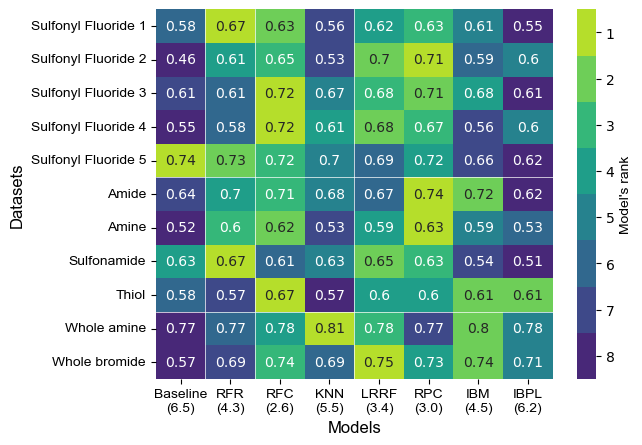

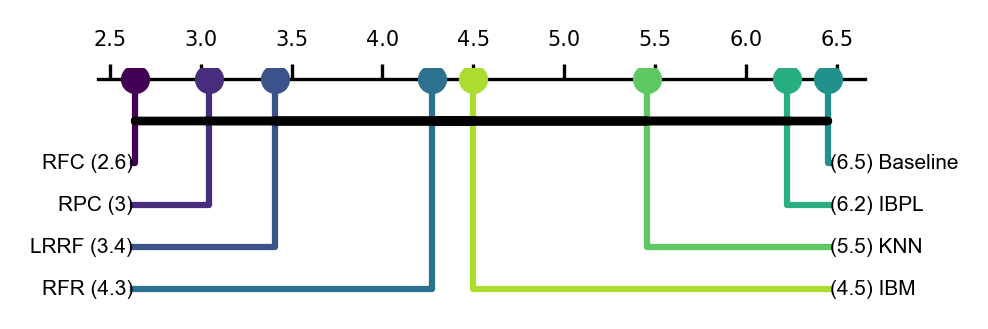

In [7]:
plot_rr_heatmap(combined_rr_table, all_models_ordered, datasets)
plot_bonferroni_dunn(combined_rr_table, all_models_ordered)

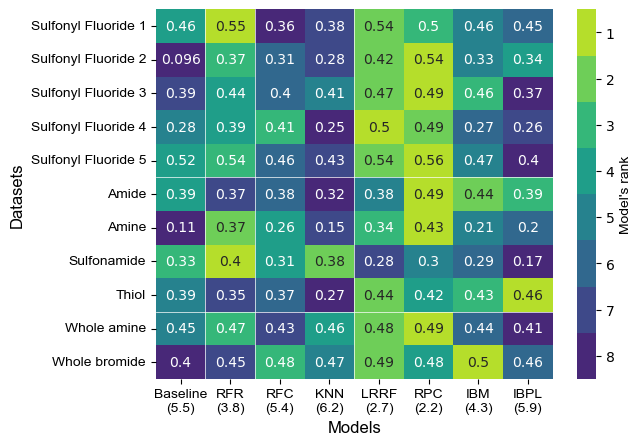

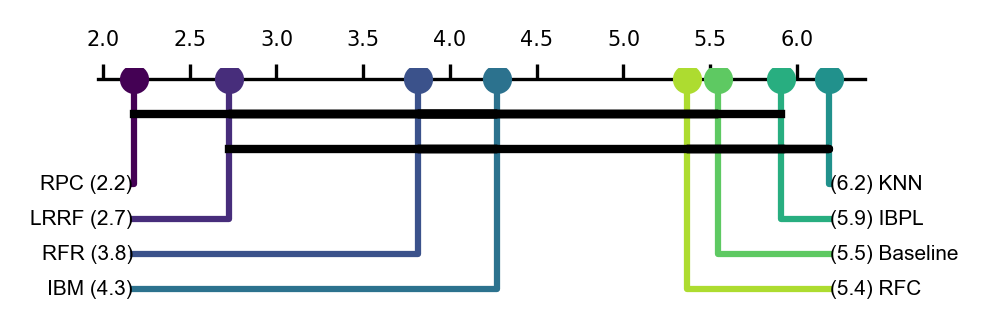

In [8]:
plot_rr_heatmap(combined_kt_table, all_models_ordered, datasets)
plot_bonferroni_dunn(combined_kt_table, all_models_ordered)

### Comparing the selections made by two different strategies

In [9]:
from matplotlib.colors import ListedColormap
from copy import deepcopy
def plot_table_with_heatmap(rr_array, model_list, dataset_list, hline_pos=[5,9], last_hline=11, vline_pos=[1,2,4], square=False, cbar_kws=None, save=False):
    """ Makes a table with heatmap."""
    ordered_rr_rank_by_dataset = rankdata(rr_array, axis=1)
    max_in_each_row = np.argmax(ordered_rr_rank_by_dataset, axis=1)
    second_in_each_row = np.argsort(ordered_rr_rank_by_dataset, axis=1)[:, -2]
    average_ranks = [round(x,1) for x in rr_array.shape[1] + 1 - np.mean(ordered_rr_rank_by_dataset, axis=0)]
    array_to_plot = np.vstack((ordered_rr_rank_by_dataset, average_ranks))
    ax = sns.heatmap(
        array_to_plot, #ordered_rr_rank_by_dataset, 
        annot=np.vstack((rr_array, average_ranks)), 
        fmt=".3f",
        cbar=False, 
        cmap=ListedColormap(["white"]), 
        square=square,
        annot_kws={"fontfamily":"arial", "fontsize":10}
    )
    ncols=len(model_list)
    for row, col in enumerate(max_in_each_row) :
        ax.texts[ncols*row + col].set_weight("bold")
        ax.texts[ncols*row + col].set_color("green")
    for row, col in enumerate(second_in_each_row) :
        ax.texts[ncols*row + col].set_weight("bold")
    ax.texts[ncols*row+ncols+np.argmin(average_ranks)].set_weight("bold")
    ax.texts[ncols*row+ncols+np.argmin(average_ranks)].set_color("green")
    ax.texts[ncols*row+ncols+np.argsort(average_ranks)[1]].set_weight("bold")
    for t in ax.texts[ncols*row+ncols:] :
        t.set_text(str(t.get_text())[:3])
    
    xticklabels = []
    for model_name, avg_rank in zip(model_list, average_ranks) :
        xticklabels.append(f"{model_name}")
    yticklabels = deepcopy(dataset_list)
    yticklabels.append("Average rank\nacross datasets")
    ax.set_xticklabels(xticklabels, fontdict={"fontfamily":"arial", "fontsize":10})
    ax.set_yticklabels(yticklabels, fontdict={"fontfamily":"arial", "fontsize":10}, rotation=0)
    ax.set_xlabel("Models", fontdict={"fontfamily":"arial", "fontsize":12, "fontweight":"bold"})
    ax.set_ylabel("Datasets", fontdict={"fontfamily":"arial", "fontsize":12, "fontweight":"bold"})
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    for v in vline_pos :
        ax.axvline(v,0,1, c="grey", lw=0.5)
    for h in hline_pos : 
        ax.axhline(h,0,1, c="grey", lw=0.5)
    ax.axhline(last_hline, 0, 1, c="black", lw=1.5)
    if type(save) == str:
        plt.savefig(f"figures/{save}", dpi=300, format="svg")

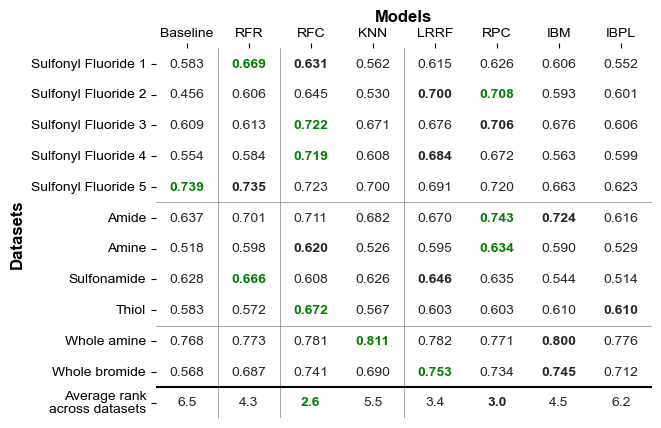

In [10]:
plot_table_with_heatmap(combined_rr_table, all_models_ordered, datasets, save="Figure4A_table_v2.svg")

In [20]:
def load_result(dataset, model1, model2):
    if "deoxy" in dataset :
        filename = "performance_excels/deoxy/desc_base_None.xlsx"
        kth = int(dataset[-1])
    elif "nature" in dataset :
        filename = f"performance_excels/natureHTE/desc_{dataset.split('_')[1]}_None.xlsx"
    elif "science" in dataset :
        filename = f"performance_excels/scienceMALDI/desc_whole_{dataset.split('_')[1]}_None.xlsx"
    result_df = pd.read_excel(filename)
    model1_df = result_df[result_df["model"]==model1]
    model2_df = result_df[result_df["model"]==model2]
    # The deoxy dataset records results for all sulfonyl fluorides in a single file.
    if "deoxy" in dataset :
        assert model1_df.shape[0] == 160
        assert model2_df.shape[0] == 160
        model1_df = model1_df.iloc[32*(kth-1):32*kth]
        model2_df = model2_df.iloc[32*(kth-1):32*kth]
    return model1_df, model2_df


def compare_specific_recommendations(dataset, model1, model2, vmax=25, vmin=-20, save=False):
    """Draws a heatmap of the rank of the suggestions made by each model.
    
    Parameters
    ----------
    dataset: str {deoxy1, deoxy2, deoxy3, deoxy4, deoxy5, nature_amide, nature_amine, nature_sulfonamide, nature_thiol, science_amine, science_bromide}
        Name of dataset to compare
    model1, model2: str
        Name of models to compare.
    save : bool
        Whether to save the plot.

    Returns
    -------
    None
    """
    # 1) Load the result excel
    model1_df, model2_df = load_result(dataset, model1, model2)
    # 2) Go through each tested substrate
    # Since RFR has been recorded multiple times, we will jist evaluate once
    counts = np.zeros((4,4)) # row : model1, col: model2
    bins = [0.33, 0.5, 1]
    for i in range(min(model1_df.shape[0], model2_df.shape[0])) :
        mrr_vals = np.array([model1_df.iloc[i,2], model2_df.iloc[i,2]])
        counts[np.digitize(mrr_vals, bins)[0], np.digitize(mrr_vals, bins)[1]] += 1

    # 3) Draw the heatmap
    fig, ax = plt.subplots(figsize=(2,3.6), nrows=2, tight_layout=True)
    sns.heatmap(counts, annot=True, square=True, cbar=False, annot_kws={"fontsize":6, "fontfamily":"arial"}, ax=ax[0], cmap="viridis")
    ax[0].set_xlabel(f"Rank of {model2} selection", fontdict={"fontfamily":"arial", "fontsize":8, "fontweight":"bold"})
    ax[0].set_ylabel(f"Rank of {model1} selection", fontdict={"fontfamily":"arial", "fontsize":8, "fontweight":"bold"})
    ax[0].set_xticklabels(5-np.arange(1,5), fontdict={"fontfamily":"arial", "fontsize":6})
    ax[0].set_yticklabels(5-np.arange(1,5), fontdict={"fontfamily":"arial", "fontsize":6})
    ax[0].xaxis.tick_top()
    ax[0].xaxis.set_label_position('top')

    # 4) Getting regrets
    regrets = []
    for i in range(min(model1_df.shape[0], model2_df.shape[0])) :
        regret_vals = np.array([model1_df.iloc[i,4], model2_df.iloc[i,4]])
        if regret_vals[0] != regret_vals[1] :
            regrets.append(regret_vals[0] - regret_vals[1])
    regrets = np.sort(np.array(regrets))[::-1]

    # 5) Plotting regrets
    ax[1].bar(np.arange(len(regrets)), regrets, width=0.9, color=["#5ec962"]*len(np.where(regrets>0)[0])+["#3b528b"]*len(np.where(regrets <0)[0]))
    # xticks, yticks = ax[1].get_xticks, ax[1].get_yticks()
    ax[1].set_ylim(vmin, vmax)
    ax[1].set_yticks([-20, -10, 0, 10,20])
    ax[1].set_yticklabels([-20, -10, 0, 10,20], fontdict={"fontfamily":"arial", "fontsize":6})
    # ax[1].set_yticklabels([round(y) for y in yticks], fontdict={"fontfamily":"arial", "fontsize":6})
    ax[1].set_xticks(np.arange(len(regrets)))
    ax[1].set_xticklabels(np.arange(1, len(regrets)+1), fontdict={"fontfamily":"arial", "fontsize":6})
    ax[1].set_xlabel("Differently predicted substrates", fontdict={"fontfamily":"arial", "fontsize":8, "fontweight":"bold"})
    ax[1].set_ylabel(f"Yield({model2}) - Yield({model1}) (%)", fontdict={"fontfamily":"arial", "fontsize":8, "fontweight":"bold"})
    ax[1].axhline(0, 0, 1, color="k", linewidth=0.5)
    for axis in ["top", "bottom", "left", "right"]:
        ax[1].spines[axis].set_linewidth(1.5)

    if save :
        plt.savefig(f"figures/{dataset}_{model1}_{model2}_v2.svg", format="svg", dpi=300)
    return regrets

array([ 24,  10,   7,   6,   5,   3,   2,  -3,  -3, -10, -19])

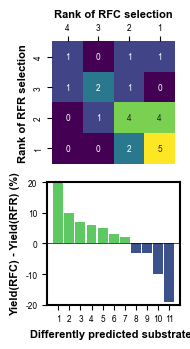

In [21]:
compare_specific_recommendations("nature_thiol", "RFR", "RFC", True)

array([ 20,  17,   7,   4,   3,   2,   2,   1,  -3,  -7, -12])

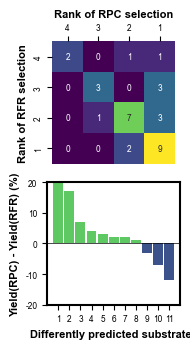

In [22]:
compare_specific_recommendations("deoxy2", "RFR", "RPC", True)

#### all cases

In [ ]:
for i in range(1,6):
    compare_specific_recommendations(f"deoxy{i}", "RFR", "RPC")

In [ ]:
nucleophile_names = ["amide", "amine", "sulfonamide", "thiol"]
for i in nucleophile_names:
    compare_specific_recommendations(f"nature_{i}", "RFR", "RPC", vmax=50, vmin=-50)

## Onehot

In [ ]:
ohe_analyzer = Analyzer("onehot", rf_based_models_ordered, 0)
ohe_perf_df = ohe_analyzer.avg_perf_df
ohe_rr_table, ohe_kt_table = get_rr_kt_tables(ohe_perf_df, rf_based_models_ordered[1:])

# To compared with physical descriptors
desc_rr_table, desc_kt_table = get_rr_kt_tables(desc_perf_df, rf_based_models_ordered[1:])

In [ ]:
plot_rr_heatmap(desc_kt_table - ohe_kt_table, rf_based_models_ordered[1:], datasets)

In [ ]:
plot_rr_heatmap(desc_rr_table - ohe_rr_table, rf_based_models_ordered[1:], datasets)

## Random descriptors

In [ ]:
rand_analyzer = Analyzer("random", rf_based_models_ordered[1:], 0)
rand_perf_df = rand_analyzer.avg_perf_df
rand_rr_table, rand_kt_table = get_rr_kt_tables(rand_perf_df, rf_based_models_ordered[1:])

In [ ]:
plot_rr_heatmap(desc_kt_table - rand_kt_table, rf_based_models_ordered[1:], datasets)

In [ ]:
plot_rr_heatmap(desc_rr_table - rand_rr_table, rf_based_models_ordered[1:], datasets)

# Datasets randomly missing 25%

In [12]:
## For the NN_based models
m1_fp_analyzer = Analyzer("fp", all_models_ordered, 1)
m1_fp_perf_df = m1_fp_analyzer.avg_perf_df

# 
m1_desc_analyzer = Analyzer("desc", rf_based_models_ordered, 1)
m1_desc_perf_df = m1_desc_analyzer.avg_perf_df

# Then combine with the nearest-neighbor based models
m1_combined_avg_perf_df = pd.concat([
    m1_fp_perf_df[m1_fp_perf_df["model"].isin(["KNN", "IBM", "IBPL"])], 
    m1_desc_perf_df
])

m1_combined_rr_table, m1_combined_kt_table = get_rr_kt_tables(m1_combined_avg_perf_df, all_models_ordered)
m1_p_combined_rr, m1_p_combined_kt = run_friedman_tests(m1_combined_rr_table, m1_combined_kt_table, all_models_ordered)

print(m1_p_combined_rr, m1_p_combined_kt)

0.00015031475784421482 2.7850436958423737e-08


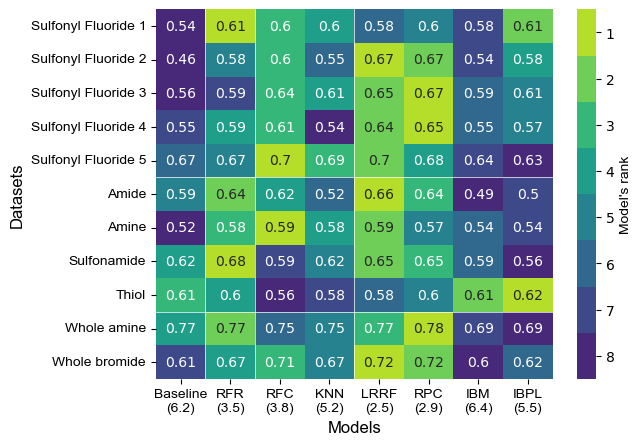

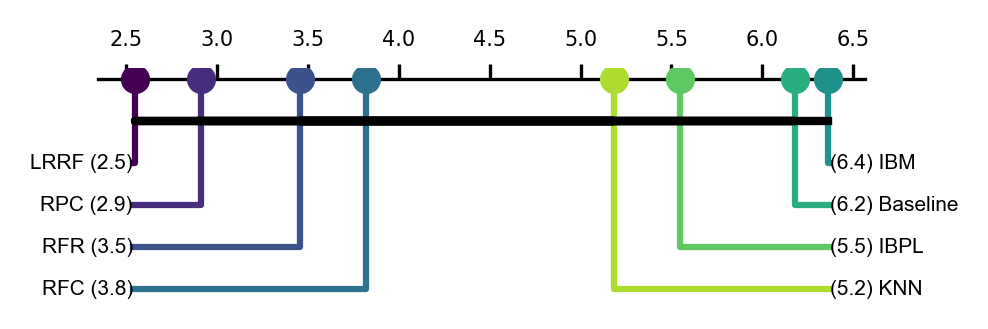

In [13]:
plot_rr_heatmap(m1_combined_rr_table, all_models_ordered, datasets)
plot_bonferroni_dunn(m1_combined_rr_table, all_models_ordered)

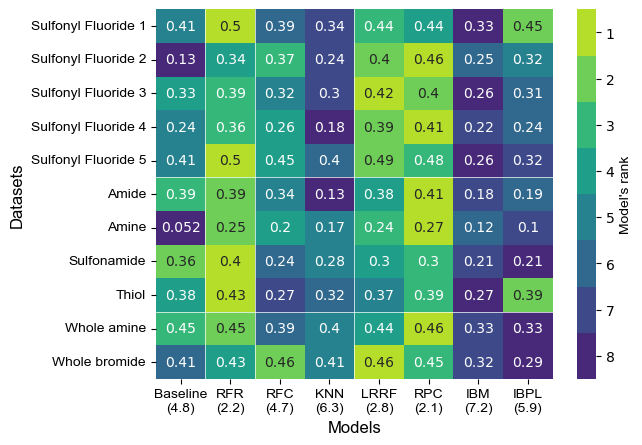

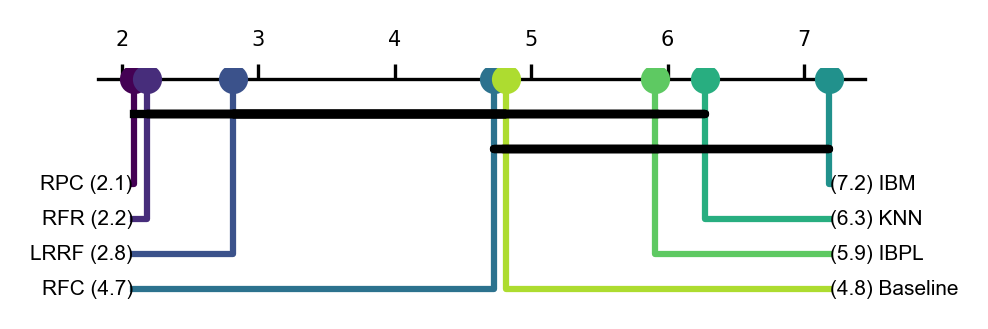

In [14]:
plot_rr_heatmap(m1_combined_kt_table, all_models_ordered, datasets)
plot_bonferroni_dunn(m1_combined_kt_table, all_models_ordered)

# Datasets randomly missing 50%

In [23]:
## For the NN_based models
m2_fp_analyzer = Analyzer("fp", all_models_ordered, 2)
m2_fp_perf_df = m2_fp_analyzer.avg_perf_df

# 
m2_desc_analyzer = Analyzer("desc", rf_based_models_ordered, 2)
m2_desc_perf_df = m2_desc_analyzer.avg_perf_df

# Then combine with the nearest-neighbor based models
m2_combined_avg_perf_df = pd.concat([
    m2_fp_perf_df[m2_fp_perf_df["model"].isin(["KNN", "IBM", "IBPL"])], 
    m2_desc_perf_df
])

m2_combined_rr_table, m2_combined_kt_table = get_rr_kt_tables(m2_combined_avg_perf_df, all_models_ordered)
m2_p_combined_rr, m2_p_combined_kt = run_friedman_tests(m2_combined_rr_table, m2_combined_kt_table, all_models_ordered)

print(m2_p_combined_rr, m2_p_combined_kt)

0.00045015843379107097 5.712570796878898e-07


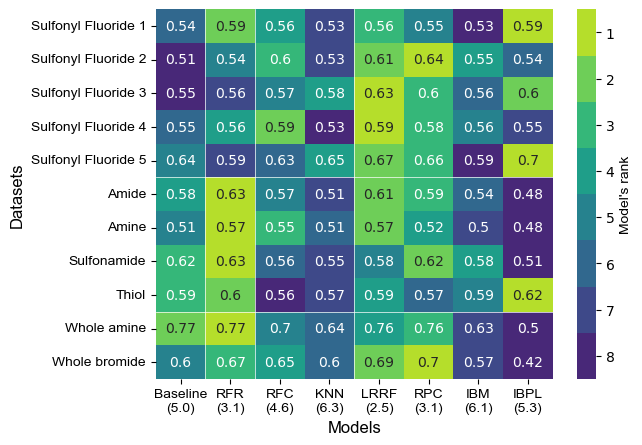

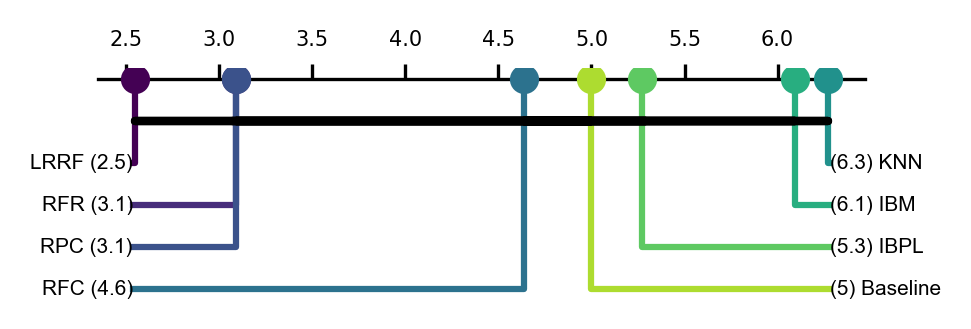

In [24]:
plot_rr_heatmap(m2_combined_rr_table, all_models_ordered, datasets)
plot_bonferroni_dunn(m2_combined_rr_table, all_models_ordered)

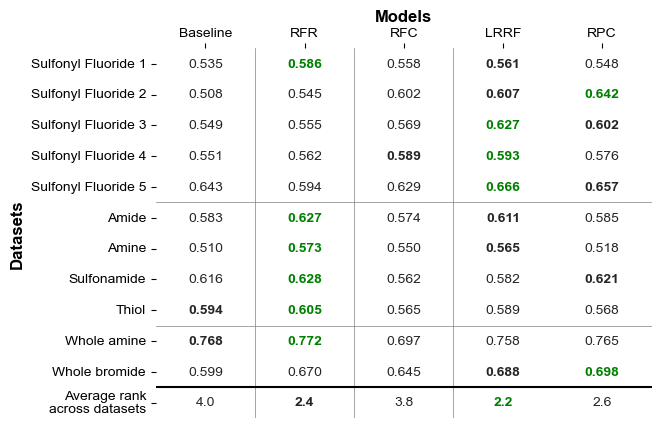

In [25]:
m2_desc_rr_table, m2_desc_kt_table = get_rr_kt_tables(m2_desc_perf_df, rf_based_models_ordered)
plot_table_with_heatmap(m2_desc_rr_table, rf_based_models_ordered, datasets, vline_pos=[1,2,3], save="Figure5A_table.svg")

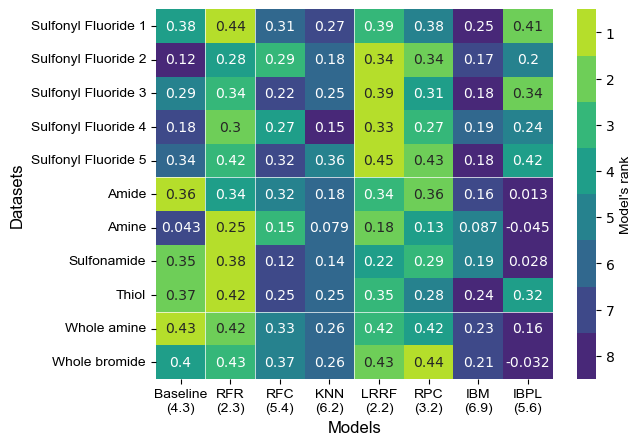

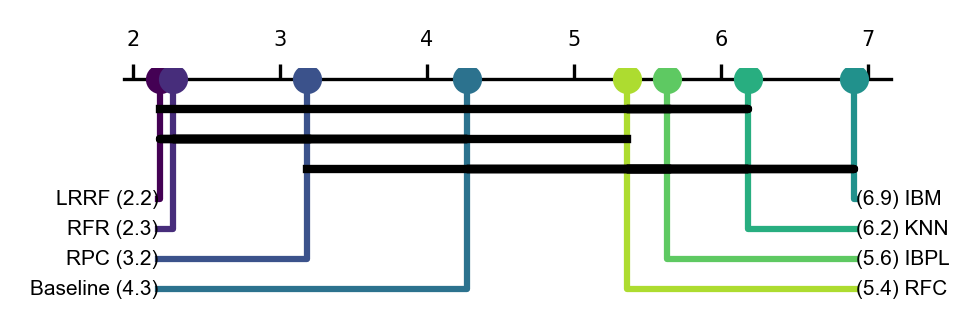

In [26]:
plot_rr_heatmap(m2_combined_kt_table, all_models_ordered, datasets)
plot_bonferroni_dunn(m2_combined_kt_table, all_models_ordered)

# All data schemes together

### Drawing a trendline trellis

In [ ]:
full_df = pd.concat([combined_avg_perf_df, m1_combined_avg_perf_df, m2_combined_avg_perf_df])
full_df["Missing Portion"] = [0]*combined_avg_perf_df.shape[0] + [25]*m1_combined_avg_perf_df.shape[0] + [50] * m2_combined_avg_perf_df.shape[0]

fig, ax = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, tight_layout=True, figsize=(6.9,5.2))
for i, dataset_to_plot in enumerate(full_df["dataset"].unique()) :
    row = i // 4
    col = i % 4
    sns.lineplot(
        full_df[
            (full_df["model"].isin(["RFR","RFC","LRRF","RPC"])) &\
            (full_df["dataset"]==dataset_to_plot)
        ], 
        x="Missing Portion", y="average reciprocal rank",
        hue="model", style="model", ax=ax[row, col], markers=True,
        palette="plasma",
        markersize=8, alpha=0.7
    )
    ax[row, col].set_xticks([0,25,50])
    ax[row, col].set_yticks([0.5+0.1*x for x in range(4)])
    if row == 2 :
        ax[row, col].set_xticklabels([0,25,50], fontdict={"fontsize":10, "fontfamily":"arial"})
        ax[row, col].set_xlabel("")
    if col == 0 :
        ax[row, col].set_yticklabels([0.5+0.1*x for x in range(4)], fontdict={"fontsize":10, "fontfamily":"arial"})
        ax[row, col].set_ylabel("")
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[row, col].spines[axis].set_linewidth(1.5)
    if row == 0 and col == 3 :
        l = ax[row, col].legend(bbox_to_anchor=(1.01,0.99)) 
        plt.setp(l.texts, family="arial", size=10)
        pass
    else :
        ax[row, col].get_legend().remove()
    title = dataset_to_plot.split("-")[1]
    if "sulfonyl" in title :
        ind_num = int(title[-1])+1
        ax[row, col].set_title(title[:-1]+str(ind_num), fontsize=10, fontfamily="arial")
    else :
        ax[row, col].set_title(title, fontsize=10, fontfamily="arial")

fig.text(0.01, 0.5, "Mean Reciprocal Rank", ha="center", va="center", rotation="vertical", fontdict={"fontsize":12, "fontfamily":"arial"})
fig.text(0.47, 0.01, "Missing Data (%)", ha="center", va="center", fontdict={"fontsize":12, "fontfamily":"arial"})
# plt.savefig("figures/Figure5_v1.svg", dpi=300, format="svg")

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, tight_layout=True, figsize=(6.9,5.2))
for i, dataset_to_plot in enumerate(full_df["dataset"].unique()) :
    row = i // 4
    col = i % 4
    ax.barplot(
        full_df[
            (full_df["model"].isin(["RFR","RFC","LRRF","RPC"])) &\
            (full_df["dataset"]==dataset_to_plot)
        ], 
        x="Missing Portion", y="average reciprocal rank",
        hue="model", style="model", ax=ax[row, col], markers=True,
        palette="plasma",
        markersize=8, alpha=0.7
    )
    ax[row, col].set_xticks([0,25,50])
    ax[row, col].set_yticks([0.5+0.1*x for x in range(4)])
    if row == 2 :
        ax[row, col].set_xticklabels([0,25,50], fontdict={"fontsize":10, "fontfamily":"arial"})
        ax[row, col].set_xlabel("")
    if col == 0 :
        ax[row, col].set_yticklabels([0.5+0.1*x for x in range(4)], fontdict={"fontsize":10, "fontfamily":"arial"})
        ax[row, col].set_ylabel("")
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[row, col].spines[axis].set_linewidth(1.5)
    if row == 0 and col == 3 :
        l = ax[row, col].legend(bbox_to_anchor=(1.01,0.99)) 
        plt.setp(l.texts, family="arial", size=10)
        pass
    else :
        ax[row, col].get_legend().remove()
    title = dataset_to_plot.split("-")[1]
    if "sulfonyl" in title :
        ind_num = int(title[-1])+1
        ax[row, col].set_title(title[:-1]+str(ind_num), fontsize=10, fontfamily="arial")
    else :
        ax[row, col].set_title(title, fontsize=10, fontfamily="arial")

fig.text(0.01, 0.5, "Mean Reciprocal Rank", ha="center", va="center", rotation="vertical", fontdict={"fontsize":12, "fontfamily":"arial"})
fig.text(0.47, 0.01, "Missing Data (%)", ha="center", va="center", fontdict={"fontsize":12, "fontfamily":"arial"})

In [ ]:
# Showing examples with largest decrease in MRR scores
mrr_diff = np.zeros((4, 11))
models_to_consider = ["RFR", "RFC", "LRRF", "RPC"]
datasets = full_df["dataset"].unique()
for i, dataset in enumerate(datasets):
    for j, model in enumerate(models_to_consider):
        mrr_vals = full_df[
            (full_df["dataset"] == dataset) &\
            (full_df["model"] == model)
        ]["average reciprocal rank"]
        mrr_diff[j, i] = mrr_vals.iloc[-1] - mrr_vals.iloc[0]


# datasets_to_consider = [np.unravel_index(np.argmin(x, axis=None), x.shape)[1] for x in [mrr_diff[:, :5], mrr_diff[:, 5:9], mrr_diff[:, 9:]]]
datasets_to_consider = [np.argmin(np.mean(x, axis=0)) for x in [mrr_diff[:, :5], mrr_diff[:, 5:9], mrr_diff[:, 9:]]]
datasets_to_consider[1] += 5
datasets_to_consider[2] += 9
partial_mrr_diff = mrr_diff[:, datasets_to_consider]

pal = sns.cubehelix_palette(4, rot=-.25, light=.7)

# fig, ax = plt.subplots(ncols=3, sharey=True, tight_layout=True, figsize=(3.3, 2))
fig, ax = plt.subplots(layout="constrained", figsize=(3.3, 2))
dataset_names = [full_df["dataset"].unique()[x].split("-")[1] for x in datasets_to_consider]
dataset_names[0] = "sulfonyl fluoride 3"
decreases = {
    x:partial_mrr_diff[i] for i, x in enumerate(models_to_consider)
}
x = np.arange(len(dataset_names))
width=0.15
multiplier = -0.5

for i, (model, diff) in enumerate(decreases.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, diff, width, label=model, color=pal[3-i])
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize":6, "fontfamily":"arial"})
ax.set_ylabel('MRR Difference', fontdict={"fontsize":8, "fontfamily":"arial"})
ax.set_xticks(x + width, dataset_names)
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontdict={"fontsize":6, "fontfamily":"arial"})
ax.set_xlabel("Dataset", fontdict={"fontsize":8, "fontfamily":"arial"})
ax.legend(loc='lower right', fontsize=6, prop={"size":6, "family":"arial"})
plt.savefig("figures/Figure5B_v1.svg", dpi=300, format="svg")

In [ ]:
decreases = {
    x:mrr_diff[i] for i, x in enumerate(models_to_consider)
}
datasets = [f"Deoxy-sulfonyl fluoride {i+1}" for i in range(5)] + list(datasets)[5:]
dataset_names = [x.split("-")[1] for x in datasets]
x = np.arange(len(datasets))
width=0.15
multiplier = -0.5

fig, ax = plt.subplots(figsize=(7,3.5))
for i, (model, diff) in enumerate(decreases.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, diff, width, label=model, color=pal[3-i])
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize":6, "fontfamily":"arial"})
ax.set_ylabel('MRR Difference', fontdict={"fontsize":8, "fontfamily":"arial"})
ax.set_xticks(x + width, dataset_names)
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontdict={"fontsize":6, "fontfamily":"arial"})
ax.set_xlabel("Dataset", fontdict={"fontsize":8, "fontfamily":"arial"})
ax.legend(loc='lower right', fontsize=6, prop={"size":6, "family":"arial"})
ax.axhline(0, 0, 1, c="black")
# plt.savefig("figures/Figure5B_v1.svg", dpi=300, format="svg")

### Comparing robustness against missing reactions

In [ ]:
# Student t-test of decrease in performance by missing reactions 
m2_diff = m2_combined_rr_table - combined_rr_table

rf_models = ["RFR", "RFC", "LRRF", "RPC"]
m2_p_vals = np.zeros((len(rf_models), len(rf_models)))
for model1, model2 in combinations(rf_models, 2) :
    t, p = ttest_ind(m2_diff[model1].to_numpy(), m2_diff[model2].to_numpy())
    print(model1, model2, p)
# AFter the Bonferonni correction, LRRF is the only one significantly better than RFC
# in terms of degradation in performance

### Comparing variation between different folds

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(3.3, 7), sharex=True, tight_layout=True)

desc_m1_deoxy_perf_df = m1_desc_analyzer.deoxy_perf_df
desc_m1_deoxy_perf_df["sulfonyl_fluoride"] = [i//1600 + 1 for i in range(desc_m1_deoxy_perf_df.shape[0])]
mean_rr_df = desc_m1_deoxy_perf_df.groupby([
    "model", "test_compound", "evaluation_loop", "sulfonyl_fluoride"
])["reciprocal_rank"].mean().reset_index() # Average across each CV test fold
m1_deoxy_var_df = mean_rr_df.groupby([
    "model", "test_compound", "sulfonyl_fluoride"
])["reciprocal_rank"].std().reset_index() # Standard deviation across each random mask
sub_m1_deoxy_df = m1_deoxy_var_df[m1_deoxy_var_df["model"].isin(rf_models)]
sns.swarmplot(
    sub_m1_deoxy_df, 
    x="model", y="reciprocal_rank", hue="sulfonyl_fluoride", dodge=True,
    palette="viridis", order=rf_models,
    ax=ax[0], legend=False
)

m1_nature_dfs = [m1_desc_analyzer.amide_perf_df, m1_desc_analyzer.amine_perf_df, m1_desc_analyzer.sulfon_perf_df, m1_desc_analyzer.thiol_perf_df]
nature_datasets = ["Amide", "Amine", "Sulfonamide", "Thiol"]

m1_nature_var_dfs = []
for m1_df, name in zip(m1_nature_dfs, nature_datasets) : 
    mean_rr_df = m1_df.groupby(["model", "test_compound", "evaluation_loop"])["reciprocal_rank"].mean().reset_index()
    var_df = mean_rr_df.groupby(["model", "test_compound"])["reciprocal_rank"].std().reset_index()
    var_df["dataset"] = [name] * var_df.shape[0]
    m1_nature_var_dfs.append(var_df)

m1_nature_var_df = pd.concat(m1_nature_var_dfs)
sns.swarmplot(
    m1_nature_var_df[m1_nature_var_df["model"].isin(rf_models)], 
    x="model", y="reciprocal_rank", hue="dataset", dodge=True,palette="viridis", order=rf_models,
    ax=ax[1], legend=False
)

science_datasets = ["whole_amine", "whole_bromide"]
m1_science_dfs = [m1_desc_analyzer.whole_amine_perf_df, m1_desc_analyzer.whole_bromide_perf_df]

m1_science_var_dfs = []
for m1_df, name in zip(m1_science_dfs, science_datasets) : 
    mean_rr_df = m1_df.groupby(["model", "test_compound", "evaluation_loop"])["reciprocal_rank"].mean().reset_index()
    var_df = mean_rr_df.groupby(["model", "test_compound"])["reciprocal_rank"].std().reset_index()
    var_df["dataset"] = [name] * var_df.shape[0]
    m1_science_var_dfs.append(var_df)

m1_science_var_df = pd.concat(m1_science_var_dfs)
sns.swarmplot(
    m1_science_var_df[m1_science_var_df["model"].isin(rf_models)], 
    x="model", y="reciprocal_rank", hue="dataset", dodge=True,palette="viridis", order=rf_models,
    ax=ax[2], legend=False
)

ax[0].set_yticks([0, 0.05, 0.10, 0.15])
ax[0].set_yticklabels([0, 0.05, "0.10", 0.15], fontdict={"fontfamily":"arial", "fontsize":10})
ax[1].set_yticks([0, 0.06, 0.12, 0.18])
ax[1].set_yticklabels([0, 0.06, 0.12, 0.18], fontdict={"fontfamily":"arial", "fontsize":10})
ax[2].set_yticks([0, 0.02, 0.04, 0.06])
ax[2].set_yticklabels([0, 0.02, 0.04, 0.06], fontdict={"fontfamily":"arial", "fontsize":10})

datasets = ["Deoxyfluorination", "Nature", "Science"]
for i in range(3):
    ax[i].set_title(datasets[i], fontdict={"fontfamily":"arial", "fontsize":10})
    if i!= 1 :
        ax[i].set_ylabel("")
    else :
        ax[i].set_ylabel("Standard Deviation of MRR", fontdict={"fontfamily":"arial", "fontsize":12})
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[i].spines[axis].set_linewidth(1.5)
    for j in range(1,4):
        ax[i].axvline(j-0.5, 0, 1, c="grey", ls="--", alpha=0.5)
ax[2].set_xlabel("Model", fontdict={"fontfamily":"arial", "fontsize":12})    
ax[2].set_xticklabels(rf_models, fontdict={"fontfamily":"arial", "fontsize":10})    

In [ ]:
desc_m2_deoxy_perf_df = m2_desc_analyzer.deoxy_perf_df
new_comp_starts_at = [0]
rfr_inds = desc_m2_deoxy_perf_df[desc_m2_deoxy_perf_df["model"]=="RFR"].index.tolist()
for i, ind in enumerate(rfr_inds) :
    if i> 0 :
        if ind - rfr_inds[i-1] > 1 :
            new_comp_starts_at.append(ind)
print("NEW COMPOUND STARTS", new_comp_starts_at)

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(3.3, 7), sharex=True, tight_layout=True)

desc_m2_deoxy_perf_df["sulfonyl_fluoride"] = [i//1600 + 1 for i in range(desc_m2_deoxy_perf_df.shape[0])]
mean_rr_df = desc_m2_deoxy_perf_df.groupby([
    "model", "test_compound", "evaluation_loop", "sulfonyl_fluoride"
])["reciprocal_rank"].mean().reset_index() # Average across each CV test fold
m2_deoxy_var_df = mean_rr_df.groupby([
    "model", "test_compound", "sulfonyl_fluoride"
])["reciprocal_rank"].std().reset_index() # Standard deviation across each random mask
sub_m2_deoxy_df = m2_deoxy_var_df[m2_deoxy_var_df["model"].isin(rf_models)]
sns.swarmplot(
    sub_m2_deoxy_df, 
    x="model", y="reciprocal_rank", hue="sulfonyl_fluoride", dodge=True,
    palette="viridis", order=rf_models,
    ax=ax[0], legend=False
)

m2_nature_dfs = [m2_desc_analyzer.amide_perf_df, m2_desc_analyzer.amine_perf_df, m2_desc_analyzer.sulfon_perf_df, m2_desc_analyzer.thiol_perf_df]
nature_datasets = ["Amide", "Amine", "Sulfonamide", "Thiol"]

m2_nature_var_dfs = []
for m2_df, name in zip(m2_nature_dfs, nature_datasets) : 
    mean_rr_df = m2_df.groupby(["model", "test_compound", "evaluation_loop"])["reciprocal_rank"].mean().reset_index()
    var_df = mean_rr_df.groupby(["model", "test_compound"])["reciprocal_rank"].std().reset_index()
    var_df["dataset"] = [name] * var_df.shape[0]
    m2_nature_var_dfs.append(var_df)

m2_nature_var_df = pd.concat(m2_nature_var_dfs)
sns.swarmplot(
    m2_nature_var_df[m2_nature_var_df["model"].isin(rf_models)], 
    x="model", y="reciprocal_rank", hue="dataset", dodge=True,palette="viridis", order=rf_models,
    ax=ax[1], legend=False
)

m2_science_dfs = [m2_desc_analyzer.whole_amine_perf_df, m2_desc_analyzer.whole_bromide_perf_df]

m2_science_var_dfs = []
for m2_df, name in zip(m2_science_dfs, science_datasets) : 
    mean_rr_df = m2_df.groupby(["model", "test_compound", "evaluation_loop"])["reciprocal_rank"].mean().reset_index()
    var_df = mean_rr_df.groupby(["model", "test_compound"])["reciprocal_rank"].std().reset_index()
    var_df["dataset"] = [name] * var_df.shape[0]
    m2_science_var_dfs.append(var_df)

m2_science_var_df = pd.concat(m2_science_var_dfs)
sns.swarmplot(
    m2_science_var_df[m2_science_var_df["model"].isin(rf_models)], 
    x="model", y="reciprocal_rank", hue="dataset", dodge=True,palette="viridis", order=rf_models,
    ax=ax[2], legend=False
)

ax[0].set_yticks([0, 0.05, 0.10, 0.15])
ax[0].set_yticklabels([0, 0.05, "0.10", 0.15], fontdict={"fontfamily":"arial", "fontsize":10})
ax[1].set_yticks([0, 0.06, 0.12, 0.18])
ax[1].set_yticklabels([0, 0.06, 0.12, 0.18], fontdict={"fontfamily":"arial", "fontsize":10})
ax[2].set_yticks([0, 0.02, 0.04, 0.06])
ax[2].set_yticklabels([0, 0.02, 0.04, 0.06], fontdict={"fontfamily":"arial", "fontsize":10})

datasets = ["Deoxyfluorination", "Nature", "Science"]
for i in range(3):
    ax[i].set_title(datasets[i], fontdict={"fontfamily":"arial", "fontsize":10})
    if i!= 1 :
        ax[i].set_ylabel("")
    else :
        ax[i].set_ylabel("Standard Deviation of MRR", fontdict={"fontfamily":"arial", "fontsize":12})
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[i].spines[axis].set_linewidth(1.5)
    for j in range(1,4):
        ax[i].axvline(j-0.5, 0, 1, c="grey", ls="--", alpha=0.5)
ax[2].set_xlabel("Model", fontdict={"fontfamily":"arial", "fontsize":12})    
ax[2].set_xticklabels(rf_models, fontdict={"fontfamily":"arial", "fontsize":10})    

In [ ]:
std_sub_m1_deoxy = sub_m1_deoxy_df.rename(columns={"reciprocal_rank":"std"})
plot_std_kde_plot(std_sub_m1_deoxy, rf_models, save="Figure5B_deoxy1.svg")

std_sub_m2_deoxy = sub_m2_deoxy_df.rename(columns={"reciprocal_rank":"std"})
plot_std_kde_plot(std_sub_m2_deoxy, rf_models, save="Figure5B_deoxy2.svg")

In [ ]:
std_sub_m1_nature = m1_nature_var_df.rename(columns={"reciprocal_rank":"std"})
std_sub_m2_nature = m2_nature_var_df.rename(columns={"reciprocal_rank":"std"})
plot_std_kde_plot(std_sub_m1_nature, rf_models, save="Figure5B_nature1.svg")
plot_std_kde_plot(std_sub_m2_nature, rf_models, save="Figure5B_nature2.svg")

In [ ]:
std_sub_m1_science = m1_science_var_df.rename(columns={"reciprocal_rank":"std"})
std_sub_m2_science = m2_science_var_df.rename(columns={"reciprocal_rank":"std"})
plot_std_kde_plot(std_sub_m1_science, rf_models, xlim=(-0.025, 0.075), xticks=[0, 0.025, 0.050, 0.075], save="Figure5B_science1.svg")
plot_std_kde_plot(std_sub_m2_science, rf_models, xlim=(-0.025, 0.075), xticks=[0, 0.025, 0.050, 0.075], save="Figure5B_science2.svg")

# Datasets with more than 10 conditions

## Complete

In [27]:
rf_models = ["Baseline", "RFR", "RFC", "LRRF", "RPC"]

### Combining Borylation and Informer using FP and Ullmann and aryl borylation using descriptors
fp_analyzer2 = MoreConditionAnalyzer("fp", ["informer", "borylation"], rf_models)
fp_perf_df2 = fp_analyzer2.avg_perf_df

In [28]:
desc_analyzer2 = MoreConditionAnalyzer("desc", ["ullmann", "aryl_borylation"], rf_models)
desc_perf_df2 = desc_analyzer2.avg_perf_df

perf_df2_comb = pd.concat([fp_perf_df2, desc_perf_df2], ignore_index=True)
rr_table2, kt_table2 = get_rr_kt_tables(perf_df2_comb, rf_models)

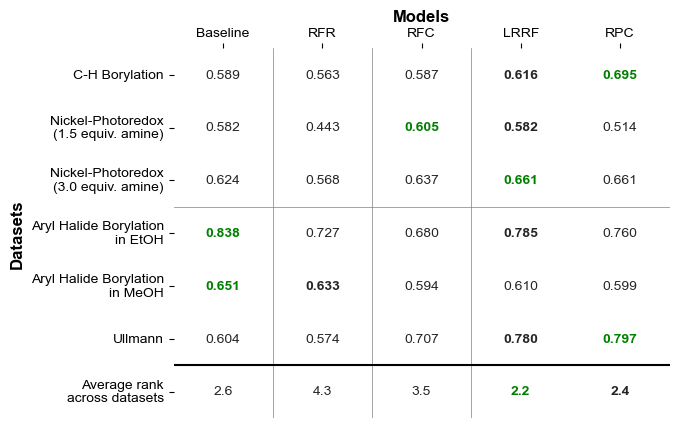

In [29]:
datasets_ordered = ["Borylation", "Informer 1", "Informer 2", "Aryl Borylation in EtOH", "Aryl Borylation in MeOH", "Ullmann"]
plot_table_with_heatmap(
    rr_table2.reindex(datasets_ordered), 
    rf_models, 
    ["C-H Borylation", "Nickel-Photoredox\n(1.5 equiv. amine)", "Nickel-Photoredox\n(3.0 equiv. amine)", "Aryl Halide Borylation\nin EtOH", "Aryl Halide Borylation\nin MeOH", "Ullmann"], 
    hline_pos=[3], last_hline=6, vline_pos=[1,2,3],
    save="Figure6A.svg"
)

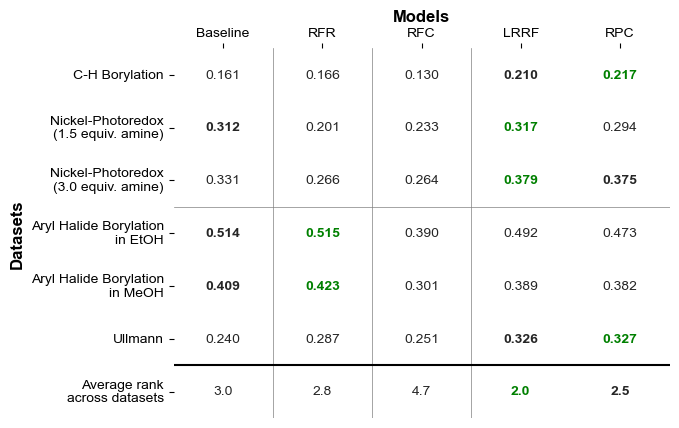

In [30]:
plot_table_with_heatmap(
    kt_table2.reindex(datasets_ordered), 
    rf_models, 
    ["C-H Borylation", "Nickel-Photoredox\n(1.5 equiv. amine)", "Nickel-Photoredox\n(3.0 equiv. amine)", "Aryl Halide Borylation\nin EtOH", "Aryl Halide Borylation\nin MeOH", "Ullmann"], 
    hline_pos=[3], last_hline=6, vline_pos=[1,2,3],
    # save="Figure6A.svg"
)

In [ ]:
fp_analyzer2 = MoreConditionAnalyzer("fp", all_models_ordered) 
fp_perf_df2 = fp_analyzer2.avg_perf_df

In [ ]:
fp_combined_rr_table2, fp_combined_kt_table2 = get_rr_kt_tables(fp_perf_df2, all_models_ordered)
plot_rr_heatmap(fp_combined_rr_table2, all_models_ordered, more_datasets, square=True, cbar_kws={"shrink":0.54})

In [ ]:
fp_combined_rr_table2, fp_combined_kt_table2 = get_rr_kt_tables(fp_perf_df2, rf_based_models_ordered)
plot_table_with_heatmap(fp_combined_rr_table2, rf_based_models_ordered, more_datasets, last_hline=4, vline_pos=[1,2,3])

In [ ]:
desc_analyzer2 = MoreConditionAnalyzer("desc", rf_based_models_ordered) 
desc_perf_df2 = desc_analyzer2.avg_perf_df

desc_combined_rr_table2, desc_combined_kt_table2 = get_rr_kt_tables(desc_perf_df2, rf_based_models_ordered)
plot_rr_heatmap(desc_combined_rr_table2, rf_based_models_ordered, more_datasets[1:], square=True, cbar_kws={"shrink":0.65}, vline_pos=[1,2,3])

## Missing ~20% data

In [ ]:
m20_fp_analyzer2 = MoreConditionAnalyzer("fp", all_models_ordered, [4, 4, 3]) 
m20_fp_perf_df2 = m20_fp_analyzer2.avg_perf_df

m20_fp_combined_rr_table2, m20_fp_combined_kt_table2 = get_rr_kt_tables(m20_fp_perf_df2, all_models_ordered)
plot_rr_heatmap(m20_fp_combined_rr_table2, all_models_ordered, more_datasets, square=True, cbar_kws={"shrink":0.54})

In [31]:
m20_desc_analyzer2 = MoreConditionAnalyzer("desc", rf_based_models_ordered, [4,4,3]) 
m20_desc_perf_df2 = m20_desc_analyzer2.avg_perf_df

m20_desc_combined_rr_table2, m20_desc_combined_kt_table2 = get_rr_kt_tables(m20_desc_perf_df2, rf_based_models_ordered)
plot_rr_heatmap(m20_desc_combined_rr_table2, rf_based_models_ordered, more_datasets[1:], square=True, cbar_kws={"shrink":0.65}, vline_pos=[1,2,3])

KeyError: "None of [Index(['Baseline', 'RFR', 'RFC', 'LRRF', 'RPC'], dtype='object', name='model')] are in the [columns]"

## Missing 50% data

In [ ]:
m50_fp_analyzer2 = MoreConditionAnalyzer("fp", all_models_ordered, [10, 9, 6]) 
m50_fp_perf_df2 = m50_fp_analyzer2.avg_perf_df

m50_fp_combined_rr_table2, m50_fp_combined_kt_table2 = get_rr_kt_tables(m50_fp_perf_df2, all_models_ordered)
plot_rr_heatmap(m50_fp_combined_rr_table2, all_models_ordered, more_datasets, square=True, cbar_kws={"shrink":0.54})

In [ ]:
m50_desc_analyzer2 = MoreConditionAnalyzer("desc", rf_based_models_ordered, [10,9,6]) 
m50_desc_perf_df2 = m50_desc_analyzer2.avg_perf_df

m50_desc_combined_rr_table2, m50_desc_combined_kt_table2 = get_rr_kt_tables(m50_desc_perf_df2, rf_based_models_ordered)
plot_rr_heatmap(m50_desc_combined_rr_table2, rf_based_models_ordered, more_datasets[1:], square=True, cbar_kws={"shrink":0.65}, vline_pos=[1,2,3])

## Deoxy dataset analysis

In [ ]:
base1_dict = prep_performance_by_model_dict("performance_excels/deoxy/fp_base_False_rem1rxns.xlsx")
base2_dict = prep_performance_by_model_dict("performance_excels/deoxy/fp_base_False_rem2rxns.xlsx")

In [ ]:
base_dicts = [{}, {}, {}, {}, {}]
for k, v in base1_dict.items():
    for i in range(5) :
        base_dicts[i].update({
            k:v.iloc[320*i:320*(i+1),:]
        })

for i in range(5):
    print(i)
    for k, v in base_dicts[i].items():
        print(k)
        # print(round(v["regret"].mean(), 1))
        print(round(v["reciprocal_rank"].mean(), 3))
    print("---------------------------")


In [ ]:
base_dicts = [{}, {}, {}, {}, {}]
for k, v in base2_dict.items():
    for i in range(5) :
        base_dicts[i].update({
            k:v.iloc[320*i:320*(i+1),:]
        })

for i in range(5):
    print(i)
    for k, v in base_dicts[i].items():
        print(k)
        # print(round(v["regret"].mean(), 1))
        print(round(v["reciprocal_rank"].mean(), 3))
    print("---------------------------")


## Informer dataset analysis

In [ ]:
amine2_dict = prep_performance_by_model_dict("performance_excels/informer/fp_amine_ratio_False_rem2rxns.xlsx")
amine4_dict = prep_performance_by_model_dict("performance_excels/informer/fp_amine_ratio_False_rem4rxns.xlsx")
amine6_dict = prep_performance_by_model_dict("performance_excels/informer/fp_amine_ratio_False_rem6rxns.xlsx")

cat4_dict = prep_performance_by_model_dict("performance_excels/informer/fp_catalyst_ratio_False_rem4rxns.xlsx")
cat8_dict = prep_performance_by_model_dict("performance_excels/informer/fp_catalyst_ratio_False_rem8rxns.xlsx")
cat12_dict = prep_performance_by_model_dict("performance_excels/informer/fp_catalyst_ratio_False_rem12rxns.xlsx")

In [ ]:
cat_dicts = [{}, {}, {}, {}]
for k, v in amine6_dict.items():
    for i in range(4) :
        cat_dicts[i].update({
            k:v.iloc[110*i:110*(i+1),:]
        })

for i in range(4):
    print(i)
    for k, v in cat_dicts[i].items():
        print(k)
        print(round(v["regret"].mean(), 3))
        print(round(v["reciprocal_rank"].mean(), 3))
        print(round(v["kendall_tau"].mean(), 3))
        print(round(v["mean_reciprocal_rank"].mean(), 3))
    print("---------------------------")


In [ ]:
cat_dicts = [{}, {}]
for k, v in cat8_dict.items():
    for i in range(2) :
        cat_dicts[i].update({
            k:v.iloc[110*i:110*(i+1),:]
        })

for i in range(2):
    print(i)
    for k, v in cat_dicts[i].items():
        print(k)
        print(round(v["regret"].mean(), 3))
        print(round(v["reciprocal_rank"].mean(), 3))
        print(round(v["kendall_tau"].mean(), 3))
        print(round(v["mean_reciprocal_rank"].mean(), 3))
    print("---------------------------")


In [ ]:
trellis_of_algs(
        cat_dicts[1],
        ["Baseline", "RFR", "LRRF", "RFC"],
        "kendall_tau",
        "mean_reciprocal_rank",
        filename=None
    )

In [ ]:
amine2_dicts = [{}, {}, {}, {}]
for k, v in amine6_dict.items():
    for i in range(4) :
        amine2_dicts[i].update({
            k:v.iloc[110*i:110*(i+1),:]
        })

for i in range(4):
    print(i)
    for k, v in amine2_dicts[i].items():
        print(k)
        print(round(v["kendall_tau"].mean(), 3))
        print(round(v["mean_reciprocal_rank"].mean(), 3))
    print("---------------------------")


In [ ]:
trellis_of_algs(
        amine2_dicts[0],
        ["Baseline", "RFR", "LRRF", "RFC"],
        "regret",
        "reciprocal_rank",
        filename=None
    )

### Looking at stability of models

In [ ]:
# amine2_dicts = [{}, {}, {}, {}]
# for k, v in amine6_dict.items():
#     for i in range(4) :
#         amine2_dicts[i].update({
#             k:v.iloc[110*i:110*(i+1),:]
#         })
# amine2_dfs = []
# std_by_model = {"model":[], "std":[]}
# for dict_obj in amine2_dicts :
#     for k, v in dict_obj.items():
#         if k in ["RFR", "LRRF", "RFC"] :
#             std_list = []
#             for i in range(11) :
#                 std_list.append(v.iloc[10*i:10*(i+1), -4].std())
#             std_by_model["std"].extend(std_list)
#             std_by_model["model"].extend([k]*len(std_list))
for a in [cat4_dict, cat8_dict, cat12_dict]:
    cat_dicts = [{}, {}]
    for k, v in a.items():
        for i in range(2) :
            cat_dicts[i].update({
                k:v.iloc[110*i:110*(i+1),:]
            })
    cat_dfs = []
    std_by_model = {"model":[], "std":[]}
    for dict_obj in cat_dicts :
        for k, v in dict_obj.items():
            if k in ["RFR", "LRRF", "RFC"] :
                std_list = []
                for i in range(11) :
                    std_list.append(v.iloc[10*i:10*(i+1), -6].std()) # -6 : kendall tau, -4: MRR
                std_by_model["std"].extend(std_list)
                std_by_model["model"].extend([k]*len(std_list))
    df = pd.DataFrame(std_by_model)
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="model", hue="model", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "std",
        bw_adjust=.5, clip_on=False,
        fill=True, alpha=1, linewidth=0.5)
    g.map(sns.kdeplot, "std", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "std")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=.05)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.show()

## NatureHTE dataset analysis

In [ ]:
sulfon_dict1 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_sulfonamide_None_rem1rxns.xlsx")
sulfon_dict2 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_sulfonamide_None_rem2rxns.xlsx")
amide_dict1 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amide_None_rem1rxns.xlsx")
amide_dict2 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amide_None_rem2rxns.xlsx")
amine_dict1 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amine_None_rem1rxns.xlsx")
amine_dict2 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amine_None_rem2rxns.xlsx")

In [ ]:
for k, v in sulfon_dict2.items():
    print(k)
    # print(round(v["regret"].mean(), 1))
    print(round(v["reciprocal_rank"].mean(), 3))
    print()

In [ ]:
for k, v in amide_dict2.items():
    print(k)
    print(round(v["regret"].mean(), 1))
    print(round(v["reciprocal_rank"].mean(), 3))
    print()

In [ ]:
for k, v in amine_dict2.items():
    print(k)
    # print(round(v["regret"].mean(), 1))
    print(round(v["reciprocal_rank"].mean(), 3))
    print()

In [ ]:
for k, v in amine_dict1.items():
    print(k)
    print(round(v["regret"].mean(), 1))
    print(round(v["reciprocal_rank"].mean(), 3))
    print()

trellis_of_algs(
        amine_dict1,
        ["Baseline", "RFR", "LRRF", "RFC"],
        "regret",
        "reciprocal_rank",
        filename=None
    )

In [ ]:
trellis_of_algs(
        amine_dict,
        ["Baseline", "RFR", "LRRF", "RFC"],
        "kendall_tau",
        "reciprocal_rank",
        filename=None
    )